#### Experiments to be sorted later

What I need to do:

-Parameter tuning of RF



Data cleaning:
-average double entries
-use maccskeys for a RF

New dataset:
-fix variability above 100 down to 100
-

In [1]:
# temporary working here to deal with double values and insert it later as new section before section joining

In [21]:
import numpy as np
import pandas as pd
import _pickle as pickle

#### 1. Modify DB data
1. Conc names & cell lines to find duplicates
2. Combine them
3. Set values above 100 to 100

In [40]:
# drugCombDB data
dta = pd.read_csv("../drugCombDBdata/synergy-score-data/REGRdrugcombs_scored.csv")
print(str(len(dta))+" different Combinations")
dta.dropna(inplace=True)

dta["Drug1"] = pd.Series(dta["Drug1"],dtype="string").str.lower()
dta["Drug2"] = pd.Series(dta["Drug2"],dtype="string").str.lower()

dta.reset_index(drop=True,inplace=True)
dta.head(2)

498865 different Combinations


,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
0,1,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54
1,2,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61


##### Concatenate Names

In [4]:
# concatenate Drug1 and 2 alphabetically - TIME: 14 mins
data = dta
sorted_conc_drugs=[]
for row in range(len(data)):
    d1 = data.iloc[row]["Drug1"]
    d2 = data.iloc[row]["Drug2"]
    if d1 < d2:
        sorted_conc_drugs.append(d1+d2+data.iloc[row]["Cell line"])
    else:
        sorted_conc_drugs.append(d2+d1+data.iloc[row]["Cell line"])
sorted_conc_drugs = pd.Series(sorted_conc_drugs)

Note: I had the problem that the concatenated names did not match the original ones. Fix this issue here and then execute the cells below for replacing the Duplikates 

In [43]:
# attach the joined names to the dataframe
numerator = pd.DataFrame(list(set(sorted_conc_drugs)))
numerator.reset_index(inplace=True)

data['drug_drug2'] = sorted_conc_drugs
data = data.join(numerator.set_index(0),on="drug_drug2",how="left")

In [44]:
#get the 2 new columns to the beginning
cols = data.columns.tolist()
cols = cols[-2:] + cols[:-2]
cols = cols[0:1] + cols[2:9] + cols[1:2] + cols[9:]
data = data[cols]
data.head()

,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,1.72,6.26,-2.75,284469,5.54
1,5-fuabt-888A2058,2,5-fu,abt-888,A2058,5.88,12.33,3.33,284469,11.61
2,5-fuabt-888A2058,3,5-fu,abt-888,A2058,3.59,11.66,2.65,284469,10.94
3,5-fuabt-888A2058,4,5-fu,abt-888,A2058,-0.85,5.15,-3.86,284469,4.43
4,5-fuazd1775A2058,5,5-fu,azd1775,A2058,12.29,15.77,10.40,29611,18.66


##### Deal with duplicates

In [45]:
print("In this dataset there are")
print(len(data["index"].unique()), " drug-drug-cell combinations")
print("that have only been tested once")
print("\n","additionally there are less than ",sum(data["index"].duplicated())/2," combinations that are tested more than once")

In this dataset there are
405745  drug-drug-cell combinations
that have only been tested once

 additionally there are less than  46554.5  combinations that are tested more than once


In [66]:
%%capture --no-stdout

countDuplikates = []
i=0


for comb in set(data[data["index"].duplicated()]["index"]):
    
    subdf = data[data["index"]==comb]
    i+=1

    #time measurement
    if i%5000 == 0:
        try:
            print("total indices ",i)
        except:
            print("some error")
    
    # for later statistics
    countDuplikates.append(len(subdf))
    
    # compute mean of each series of experiements & set it as values for the first occurence. I'll drop the rest later
    means = np.mean(subdf)
    data["HSA"][subdf.iloc[0]["ID"]-1] = means["HSA"]
    data["ZIP"][subdf.iloc[0]["ID"]-1] = means["ZIP"]
    data["Bliss"][subdf.iloc[0]["ID"]-1] = means["Bliss"]
    data["Loewe"][subdf.iloc[0]["ID"]-1] = means["Loewe"]

total indices  5000
total indices  10000
total indices  15000
total indices  20000
total indices  25000
total indices  30000
total indices  35000
total indices  40000


In [69]:
data = data.drop_duplicates(subset="index",keep="first")

##### Some Visualisations on the HSA distributions
-one source with remarkable pattern<br>
-last sources with extreme values

Text(0.5, 1.0, 'Zoom in on CLOUD data')

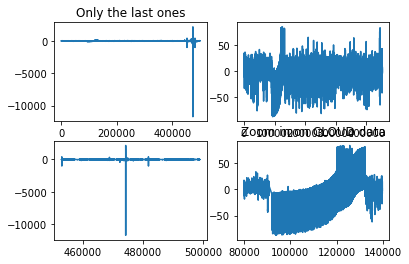

In [124]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(data["HSA"])
axis[0, 0].set_title("All HSA scores")

axis[0, 1].plot(data["HSA"][0:370000])
axis[0, 0].set_title("All except the last ones")

axis[1, 1].plot(data["HSA"][20000:70000]) #source: Cloud
axis[0, 0].set_title("Only the last ones")

axis[1, 0].plot(data["HSA"][370000:])
axis[1, 1].set_title("Zoom in on CLOUD data")

84.31
-87.82


(array([   301.,    346.,    989.,   4736., 131683., 222494.,   7504.,
          1240.,    452.,    255.]),
 array([-87.82 , -70.607, -53.394, -36.181, -18.968,  -1.755,  15.458,
         32.671,  49.884,  67.097,  84.31 ]),
 <BarContainer object of 10 artists>)

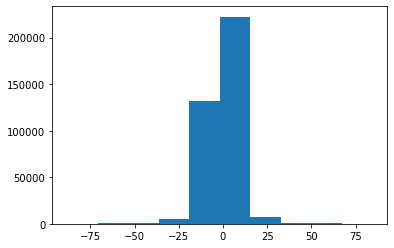

In [130]:
print(max(data["HSA"][0:370000]))
print(min(data["HSA"][0:370000]))

plt.hist(data["HSA"][0:370000])


(array([  30.,   82.,  104.,  173.,  315.,  579., 1676., 4279., 2093.,
         669.]),
 array([-77.23 , -66.439, -55.648, -44.857, -34.066, -23.275, -12.484,
         -1.693,   9.098,  19.889,  30.68 ]),
 <BarContainer object of 10 artists>)

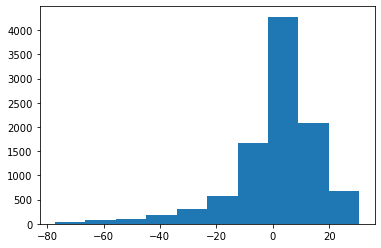

In [113]:
plt.hist(data["HSA"][40000:50000])

##### Adding source column
we see the extreme HSAs (85+ exclusively come from places where there is no source<br>
additionally many of the higher values within this range are from "CLOUD"<br>

In [137]:
sourcesData = pd.read_csv("../drugCombDBdata/drugcombs_response.csv")
groupedData = sourcesData.groupby("BlockID").first()

In [143]:
sourceToJoin = groupedData[["source","DrugRow","DrugCol"]]
sourceToJoin.rename(columns={"DrugRow":"Control DrugRow","DrugCol":"Control DrugCol"})
sourceToJoin.head(2)

,source,DrugRow,DrugCol
BlockID,,,
1,ONEIL,5-FU,ABT-888
2,ONEIL,5-FU,ABT-888


In [163]:
dataWithSource = data.join(sourceToJoin,on="ID",how="left")
dataWithSource = dataWithSource.dropna(subset=["source"])

In [168]:
dataWithSource[dataWithSource["source"]!="CLOUD"].sort_values(by="HSA")

,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA,source,DrugRow,DrugCol
252816,sorafenibtriethylenemelamineNCI-H322M,252817,triethylenemelamine,sorafenib,NCI-H322M,-35.550000,-77.070000,-81.890000,169874,-81.750000,ALMANAC,TRIETHYLENEMELAMINE,SORAFENIB
171283,nsc 85998thalidomideMOLT-4,171284,thalidomide,nsc 85998,MOLT-4,-19.550000,-60.690000,-80.860000,332285,-80.860000,ALMANAC,THALIDOMIDE,NSC 85998
189349,nsc 85998thalidomideHL-60(TB),189350,thalidomide,nsc 85998,HL-60(TB),-24.030000,-61.300000,-77.870000,384818,-77.870000,ALMANAC,THALIDOMIDE,NSC 85998
42976,mk-8776paclitaxelNCIH2122,42977,paclitaxel,mk-8776,NCIH2122,-25.180000,-79.592500,-81.175000,337195,-76.572500,ONEIL,PACLITAXEL,MK-8776
42948,geldanamycinpaclitaxelNCIH2122,42949,paclitaxel,geldanamycin,NCIH2122,-23.506719,-77.903594,-79.936875,270636,-74.693594,ONEIL,PACLITAXEL,GELDANAMYCIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239751,mitomycinensc 85998NCI-H460,239752,nsc 85998,mitomycine,NCI-H460,58.490000,56.790000,56.410000,178366,55.290000,ALMANAC,NSC 85998,MITOMYCINE
347725,actinomycin dmegestrol acetateSR,347726,megestrol acetate,actinomycin d,SR,60.420000,55.870000,36.840000,216521,55.730000,ALMANAC,MEGESTROL ACETATE,ACTINOMYCIN D
227775,mitomycinethalidomideNCI-H460,227776,thalidomide,mitomycine,NCI-H460,60.380000,59.510000,59.710000,386894,58.320000,ALMANAC,THALIDOMIDE,MITOMYCINE
359466,actinomycin dvemurafenibMOLT-4,359467,vemurafenib,actinomycin d,MOLT-4,66.630000,65.680000,58.120000,364284,63.320000,ALMANAC,VEMURAFENIB,ACTINOMYCIN D


##### Conclusion
I now will proceed doing everything with 2 datasets:<br>
data1 ... only the ones with source information and source != CLOUD <br>
data2 ... everything but cut-off at 85 <br>

In [170]:
data1 = dataWithSource[dataWithSource["source"]!="CLOUD"].drop(columns=["DrugRow","DrugCol"])
data2 = 

In [172]:
data.head(2)

,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,2.80125,9.4975,0.490625,284469,8.7775
4,5-fuazd1775A2058,5,5-fu,azd1775,A2058,9.81750,11.2075,5.837500,29611,14.0975


,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA,source
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,2.80125,9.49750,0.490625,284469,8.777500,ONEIL
4,5-fuazd1775A2058,5,5-fu,azd1775,A2058,9.81750,11.20750,5.837500,29611,14.097500,ONEIL
8,5-fubez-235A2058,9,5-fu,bez-235,A2058,2.51000,3.83750,3.667500,248202,7.597500,ONEIL
12,5-fubortezomibA2058,13,5-fu,bortezomib,A2058,-1.99625,3.62625,-2.533125,287568,1.163125,ONEIL
16,5-fudasatinibA2058,17,5-fu,dasatinib,A2058,1.50750,7.57000,11.630000,99736,12.667500,ONEIL
...,...,...,...,...,...,...,...,...,...,...,...
359692,actinomycin dcabazitaxelU251,359693,cabazitaxel,actinomycin d,U251,5.28000,6.15000,-5.530000,6570,6.440000,ALMANAC
359693,actinomycin dcabazitaxelUACC-257,359694,cabazitaxel,actinomycin d,UACC-257,2.76000,2.52000,-2.490000,67272,2.560000,ALMANAC
359694,actinomycin dcabazitaxelSR,359695,cabazitaxel,actinomycin d,SR,15.42000,9.17000,9.860000,81571,11.240000,ALMANAC
469610,clobetasone butyratehalofantrine hydrochlorideDD2,469611,clobetasone butyrate,halofantrine hydrochloride,DD2,2.28500,3.49000,-1.306000,299201,3.529000,nih


Next steps:

Train RF on these data & dummy too

Use Keys & Cell Line Profiles

##### Removing top 

In [132]:
data.head(2)

,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,2.80125,9.4975,0.490625,284469,8.7775
4,5-fuazd1775A2058,5,5-fu,azd1775,A2058,9.81750,11.2075,5.837500,29611,14.0975


In [136]:
data[data["HSA"]>300]

,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA
452986,717906-29-1pimasertib (as-703026)A-673,452987,pimasertib (as-703026),717906-29-1,A-673,300105.590,305482.130,-197.550,87541,317.760
452991,717906-29-1xmd8-92A-673,452992,xmd8-92,717906-29-1,A-673,422504.290,426035.010,381.980,266679,415.460
452998,717906-29-1pf-573228A-673,452999,pf-573228,717906-29-1,A-673,400238.360,404904.810,138.200,242915,314.230
453008,717906-29-1ncgc00344999-01A-673,453009,ncgc00344999-01,717906-29-1,A-673,261029.850,260108.660,16.810,372007,324.900
468830,epothilone blumefantrineHB3,468831,lumefantrine,epothilone b,HB3,4493.752,5509.529,1891.735,181983,338.273
474242,cyclosporin amethylene blue3D7,474243,methylene blue,cyclosporin a,3D7,1444928.571,1449993.520,2466.539,378499,2169.377
474243,atovaquonecyclosporin a3D7,474244,atovaquone,cyclosporin a,3D7,988877.233,988536.752,2696.264,347389,1075.671
481797,pf-431396pimasertibA-673,481798,pimasertib,pf-431396,A-673,300105.648,305482.184,-197.547,122236,317.758
481802,pf-431396xmd8-92A-673,481803,xmd8-92,pf-431396,A-673,422503.386,426035.115,381.598,203944,415.456
481809,pf-431396pf-573228A-673,481810,pf-573228,pf-431396,A-673,400238.017,404904.804,138.260,266336,314.231


(array([2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 6.00000e+00, 4.05732e+05, 2.00000e+00]),
 array([-11718.486 , -10329.6997,  -8940.9134,  -7552.1271,  -6163.3408,
         -4774.5545,  -3385.7682,  -1996.9819,   -608.1956,    780.5907,
          2169.377 ]),
 <BarContainer object of 10 artists>)

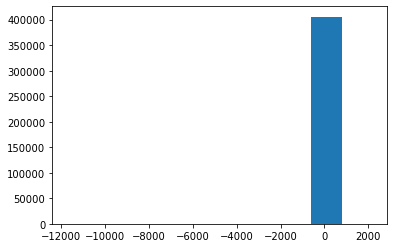

In [131]:
plt.hist(data[data"["HSA"])

In [ ]:
## do this after dropping duplicates, else everything is a duplikate

# double Data
dataReversed = dta
dataReversed = dataReversed.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})

dataDouble = dta.append(dataReversed)
dataDouble.drop("ID",axis=1,inplace=True)
dataDouble.reset_index(inplace=True)
dataDouble.drop("index",axis=1,inplace=True)

print(len(dataDouble)," records in this frame")
data=dataDouble
dataDouble.head(2)